# quick analysis output

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import frogress
import pyfits as pf
import frogress


def covariance_scalar_jck(TOTAL_PHI,jk_r, type_c = 'jackknife'):
    #  Covariance estimation
    if type_c == 'jackknife':
      fact=(jk_r-1.)/(jk_r)
    elif type_c=='bootstrap':
      fact=1./(jk_r)
    average=0.
    cov_jck=0.
    err_jck=0.
    for kk in range(jk_r):
        average+=TOTAL_PHI[kk]
    average=average/(jk_r)
    for kk in range(jk_r):
    #cov_jck+=TOTAL_PHI[kk]#*TOTAL_PHI[kk]
        cov_jck+=(-average+TOTAL_PHI[kk])*(-average+TOTAL_PHI[kk])
    err_jck=np.sqrt(cov_jck*fact)
    #average=average*(jk_r)/(jk_r-1)
    return {'cov' : cov_jck*fact,
          'err' : err_jck,
          'mean': average}

def define_jck_mask(length,n_jck):
    import math
    import random
    l_jck = math.ceil(length/n_jck)
    masks =[]
    for i in frogress.bar(range(n_jck)):
        mm = np.array([True]*length)
        mm[i*l_jck:(i+1)*l_jck] = False
        masks.append(mm)
    return masks



def produce_sn(t):
    return t[1].data['moments'][:,0]/np.sqrt(t[1].data['cov_even'][:,0])

def produce_cov(t):
    return (t[1].data['cov_even'][:,0])

def produce_mf(t):
    return t[1].data['moments'][:,0]



def sumPQR_m(tab, stampMode = False, mask = np.array([False])):
    '''Extract the total PQR for the log of probability vs shear
    given an input table with per-detection information. The
    treatment of non-detections can use two possible formulae: 
    when `stampMode=True`, we assume that there is a fixed number
    of target placements, and every row reports either a selected
    galaxy or a non-selected one, the latter including non-detections.
    For `stampMode=False` (or "Poisson" mode), we assume that galaxies
    have been placed by a Poisson process, and that there are 
    rows representing "pseudo-detections" - i.e. reporting the search
    area at a given level of noise.

    The table should have these columns:
    `SELECT`: A column which is non-zero for targets that have been selected,
       and zero for unselected detections and pseudo-detections.
    `AREA`: In stamp mode, this area gives the number of galaxy placements
       represented by the row (which can potentially be >1 if reporting
       non-detected placements.  If the entry is zero or the column is absent,
       a value of 1. will be assumed.

       In Poisson mode, this column should be zero for galaxy detections (whether
       selected or not) and should give the sky area for pseudo-detections.
    `PQR`: Taylor expansion wrt shear of probability (*not* log).
       In stamp mode, this is equal to the *detection* probability per stamp for
       any non-selected row.  In Poisson mode, this is equal to the *detection* 
       probability per unit area for any pseudo-detection.  Targets with p=0 are
       ignored.

    The output is the total log(P), and its derivs w.r.t. shear, for the full
    ensemble.'''

    if colnames['area'] in tab.columns.names:
        area = tab[colnames['area']]
        if stampMode:
            # Every entry is one stamp (at least)
            area = np.maximum(1., area)
    else:
        if stampMode:
            # Every entry is one stamp
            area = np.ones(len(tab), dtype=float)
        else:
            raise ValueError('sumPQR requires AREA column in Poisson mode')

    select = tab[colnames['select']]>0

    pqr = tab[colnames['pqr']]

    if mask.any():
        use = (pqr[:,0] > 0.) & mask
    else:
        #print ('normal')
        use = pqr[:,0] > 0.

    # First sum the log(PQR)'s for selected targets
    # ALL SUMMATIONS EXPLICITLY USE 64 BITS!!
    ss = np.logical_and(use, select)

  
    out = np.sum( logPQR(pqr[ss]), axis=0, dtype=float)

    if stampMode:
        # Sum up log(1-p) for all deselected and pseudo detections
        ss = np.logical_and(use, ~select)
        # Don't use non-detections with 100% detection probability
        ss = np.logical_and(ss, pqr[:,0]<0.999)
      
        nondet = oneMinusPQR(pqr[ss])

        out += np.sum( logPQR(nondet) * area[ss, np.newaxis], axis=0, dtype=float)
    else:
        # Poisson mode: each pseudo-detection contributes
        # log (exp(- p * A)) where p is prob per unit area
        ss = np.logical_and(use, (area>0) & (area!=1))
        # The pseudo-detections should be non-selected as well, 
        # so throw that in for good measure
        ss = np.logical_and(ss, ~select)
        out -= np.sum((pqr[ss]) *area[ss,np.newaxis], axis=0, dtype=float)*1.05

    return out


import numpy as np
from bfd.keywords import *
from bfd.pqr import *




def produce_sn(t):
    try:
        return t[1].data['moments'][:,0]/np.sqrt(t[1].data['covariance'][:,0])
    except:
        return t[1].data['moments'][:,0]/np.sqrt(t[1].data['cov_even'][:,0])
       
def produce_cov(t):
    return (t[1].data['covariance'][:,0])

def produce_mf(t):
    return t[1].data['moments'][:,0]


import pickle
def load_obj(name):
        try:
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f)#, encoding='latin1')
        except:
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f, encoding='latin1')


            
            

#out = sumPQR(targets[1].data,stampMode = True)
#g,g_cov = meanShear(out)
#print ('{0:2.6f} +- {1:2.3f}'.format(g[0],np.sqrt(-g_cov[0,0])))
#print ('{0:2.6f} +- {1:2.3f}'.format(g[1],np.sqrt(-g_cov[1,1])))

In [5]:
# paired sims path:
path_templates = '/global/cscratch1/sd/mgatti/BFD/tile_blends_reference'
path_templates = '/global/cscratch1/sd/mgatti/BFD/tile_blends_reference_1arcs_perfectdeblender_final/'

add_labels = [''] #'ISp_','ISm_']
add_labels = ['ISp_','ISm_'] #,'ISm_']
results = dict()

lens = []
for add in add_labels:
    print (add)
    target = path_templates+'/{0}targets_sample_g.fits'.format(add)
    targets = pf.open(target)
    lens.append(len(targets[1].data['ra']))
max_len = np.min(lens)
#rint (lens,lens[1]-lens[0])
    

for add in add_labels:
    print (add)
    target = path_templates+'/{0}targets_sample_g.fits'.format(add)
    targets = pf.open(target)
    results[add] = dict()
    try:
        
#        results[add]['SN'] = produce_sn(targets)[:max_len]
#        results[add]['ra'] = targets[1].data['ra'][:max_len]
#        results[add]['dec'] = targets[1].data['dec'][:max_len]
#        results[add]['photoz'] = targets[1].data['photoz'][:max_len]
#        results[add]['des_id'] = targets[1].data['des_id'][:max_len]
        results[add]['data'] = targets[1].data
    except:
        pass
    try:
    #if 1==1:
        p, q, r, mask= make_pqr(targets[1].data['PQR'][:max_len,:])
#    results[add]['p'] = np.array(p).astype(np.float64)
#    results[add]['q'] = np.array(q).astype(np.float64)
#    results[add]['r'] = np.array(r).astype(np.float64)
        results[add]['mask'] = np.array(mask)[:max_len]
        results[add]['nlost'] = len(mask)-len(mask[mask])
#        results[add]['NOISETIER'] =targets[1].data['NOISETIER'][:max_len]
        results[add]['id'] = targets[1].data['id'][:max_len]
        
    except:
        pass
    try:
        results[add]['sel'] = compute_selection(targets)
    except:
        pass

    pqr = results[add]['data'][colnames['pqr']]
    use = pqr[:,0] > 0.
    ss = np.logical_and(use, results[add]['data']['SELECT'])
        
    results[add]['R00'] = logPQR(pqr[ss])[:,5]





#try:
#    m = pf.open(path_templates+'ISp_targets_sample_g.fits')
#except:
#    m = pf.open(path_templates+'targets_sample_g.fits')
#

ISp_
ISm_
ISp_
ISm_


(array([3.046000e+03, 5.260000e+02, 8.500000e+02, 1.081000e+03,
        1.005000e+03, 9.170000e+02, 1.807000e+03, 1.171580e+05,
        1.082126e+06, 1.176759e+06]),
 array([   0. ,  218.7,  437.4,  656.1,  874.8, 1093.5, 1312.2, 1530.9,
        1749.6, 1968.3, 2187. ]),
 <BarContainer object of 10 artists>)

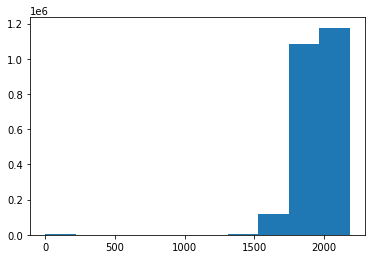

In [16]:
plt.hist(results[add]['data']['NUNIQUE'][results[add]['data']['SELECT']])

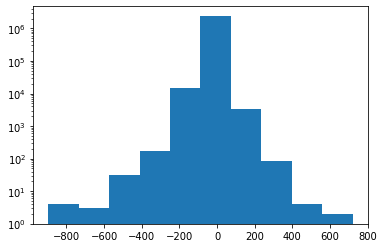

In [8]:
plt.hist( results[add]['R00'])
plt.yscale('log')

In [21]:
def sumPQR_m(tab, stampMode = False, mask = np.array([False])):
    '''Extract the total PQR for the log of probability vs shear
    given an input table with per-detection information. The
    treatment of non-detections can use two possible formulae: 
    when `stampMode=True`, we assume that there is a fixed number
    of target placements, and every row reports either a selected
    galaxy or a non-selected one, the latter including non-detections.
    For `stampMode=False` (or "Poisson" mode), we assume that galaxies
    have been placed by a Poisson process, and that there are 
    rows representing "pseudo-detections" - i.e. reporting the search
    area at a given level of noise.

    The table should have these columns:
    `SELECT`: A column which is non-zero for targets that have been selected,
       and zero for unselected detections and pseudo-detections.
    `AREA`: In stamp mode, this area gives the number of galaxy placements
       represented by the row (which can potentially be >1 if reporting
       non-detected placements.  If the entry is zero or the column is absent,
       a value of 1. will be assumed.

       In Poisson mode, this column should be zero for galaxy detections (whether
       selected or not) and should give the sky area for pseudo-detections.
    `PQR`: Taylor expansion wrt shear of probability (*not* log).
       In stamp mode, this is equal to the *detection* probability per stamp for
       any non-selected row.  In Poisson mode, this is equal to the *detection* 
       probability per unit area for any pseudo-detection.  Targets with p=0 are
       ignored.

    The output is the total log(P), and its derivs w.r.t. shear, for the full
    ensemble.'''

    if colnames['area'] in tab.columns.names:
        area = tab[colnames['area']]
        if stampMode:
            # Every entry is one stamp (at least)
            area = np.maximum(1., area)
    else:
        if stampMode:
            # Every entry is one stamp
            area = np.ones(len(tab), dtype=float)
        else:
            raise ValueError('sumPQR requires AREA column in Poisson mode')

    select = tab[colnames['select']]>0

    pqr = tab[colnames['pqr']]

    if mask.any():
        use = (pqr[:,0] > 0.) & mask
    else:
        #print ('normal')
        use = pqr[:,0] > 0.

    # First sum the log(PQR)'s for selected targets
    # ALL SUMMATIONS EXPLICITLY USE 64 BITS!!
    ss = np.logical_and(use, select)
    m1 = (logPQR(pqr[ss])[:,3]**2<200000**2)

  
    out = np.sum( logPQR(pqr[ss][m1]), axis=0, dtype=float)


    if stampMode:
        # Sum up log(1-p) for all deselected and pseudo detections
        ss = np.logical_and(use, ~select)
        # Don't use non-detections with 100% detection probability
        ss = np.logical_and(ss, pqr[:,0]<0.999)
      
        nondet = oneMinusPQR(pqr[ss])

        out += np.sum( logPQR(nondet) * area[ss, np.newaxis], axis=0, dtype=float)
    else:
        # Poisson mode: each pseudo-detection contributes
        # log (exp(- p * A)) where p is prob per unit area
        ss = np.logical_and(use, (area>0) & (area!=1))
        # The pseudo-detections should be non-selected as well, 
        # so throw that in for good measure
        ss = np.logical_and(ss, ~select)
        out -= np.sum((pqr[ss]) *area[ss,np.newaxis], axis=0, dtype=float)
        #print(np.sum((pqr[ss]) *area[ss,np.newaxis], axis=0, dtype=float))
        
    return out




stampMode = False


out = sumPQR_m(results['ISm_']['data'] ,stampMode = stampMode)
gm,g_cov = meanShear(out)
g_err = np.sqrt(g_cov.diagonal())
#


print ('')
print ('<g1>: {0:2.5f} +- {1:2.5f},   <g2>: {2:2.5f} +- {3:2.5f}'.format(-gm[0],g_err[0],gm[1],g_err[1]))
print ('m_m = {0:2.5f} +- {1:2.5f}'.format((-gm[0]/0.02+1.),g_err[0]/0.02))




out = sumPQR_m(results['ISp_']['data'] ,stampMode = stampMode)
gp,g_cov = meanShear(out)
g_err = np.sqrt(g_cov.diagonal())




print ('')
print ('<g1>: {0:2.5f} +- {1:2.5f},   <g2>: {2:2.5f} +- {3:2.5f}'.format(-gp[0],g_err[0],gp[1],g_err[1]))
print ('m_p = {0:2.5f} +- {1:2.5f}'.format(-gp[0]/0.02-1.,g_err[0]/0.02))


print ('m_diff = {0:2.5f} '.format((-gp[0]+gm[0])/(2*0.02)-1.))




<g1>: -0.01946 +- 0.00021,   <g2>: 0.00009 +- 0.00021
m_m = 0.02685 +- 0.01035

<g1>: 0.01956 +- 0.00021,   <g2>: -0.00029 +- 0.00021
m_p = -0.02182 +- 0.01035
m_diff = -0.02434 


In [21]:
import pyfits as pf
#m = pf.open('/global/cscratch1/sd/mgatti/BFD/tile_blends_reference_1arcs_deblender_final/ISp_targets_sample_g.fits')
for i in range(39):
    m = pf.open('/global/cscratch1/sd/mgatti/BFD/tile_blends_reference_1arcs_perdeblender_final/noisetiers_{0}.fits'.format(i))
    m[1].data['PQR_SEL']

In [40]:
# Function and executable that will assign noise tiers
# and interpolate selection PQR's to target files.

import sys
import numpy as np
from astropy.table import Table
import bfd
import argparse

target = '/global/cscratch1/sd/mgatti/BFD/tile_blends_reference_1arcs_deblender_final/ISp_targets_sample_g.fits'


print (i)

tab = Table.read(target)


1


In [117]:
target = '/global/cscratch1/sd/mgatti/BFD/tile_blends_reference_1arcs_deblender_final/ISm_targets_sample_g.fits'
m = pf.open(target)
mask = m[1].data['NOISETIER'] == 28
len(mask[mask])

203417

In [125]:

i=5
px = '/global/cscratch1/sd/mgatti/BFD/tile_blends_reference_1arcs_deblender_final/noisetiers_{0}.fits'.format(i)
tc = bfd.TierCollection.load(px)
#tc.assignPQRSel(tab)
#tab.write(target, overwrite=True)
m = pf.open(px)

In [128]:
m[29].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   64 / length of dimension 1                          
NAXIS2  =                   33 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'COVARIANCE'                                                          
TFORM1  = '15E     '                                                            
TTYPE2  = 'NODE_ID '                                                            
TFORM2  = '1J      '                                                            
TIER_NUM=                   

In [79]:
from bfd import Moment
tab = Table.read(target)
# ??? Need to alter the below if we are using magnification or colors
covs = None
for k in 'COV_EVEN','cov_even','covariance',colnames['covariance']:
    if k in tab.colnames:
        covs = tab[k]
        

assignments = tc.assign(covs)
m = Moment()
fluxes = None
for k in 'moments','MOMENTS':
    if k in tab.colnames:
        fluxes = tab[k][:,m.M0]
if fluxes is None:
    raise ValueError('No MOMENTS column in table')



In [90]:

# Create or read columns for PQR, tier number, select.
# Enforce uppercase
if 'pqr' in tab.colnames:
    pqr = tab['pqr'].data.copy()
    del tab['pqr']
elif colnames['pqr'] in tab.colnames:
    pqr = tab[colnames['pqr']].data.copy()
else:
    pqr = np.zeros( (covs.shape[0],6), dtype=float)

if 'select' in tab.colnames:
    select = tab['select'].data.copy()
    del tab['select']
elif 'SELECT' in tab.colnames:
    select = tab['SELECT'].data.copy()
else:
    select = np.zeros(covs.shape[0], dtype=bool)

if 'noisetier' in tab.colnames:
    targetTier = tab['noisetier'].data.copy()
    del tab['noisetier']
elif colnames['tierNumber'] in tab.colnames:
    targetTier = tab[colnames['tierNumber']].data.copy()
else:
    targetTier = np.ones(covs.shape[0], dtype=int) * -1


In [108]:

for i,t in enumerate(tc.tiers):
    print (i,t.pqrNodes)
    if t.id not in assignments:
        # No targets for this tier
        continue
    use = assignments[t.id]
    targetTier[use] = t.id
    # Find objects failing selection
    inRange = np.ones_like(use, dtype=bool)
    if t.fluxMin is not None:
        inRange = np.logical_and(inRange, fluxes[use] >= t.fluxMin)
    if t.fluxMax is not None:
        inRange = np.logical_and(inRange, fluxes[use] < t.fluxMax)
    select[use[inRange]] = True
    use = use[~inRange]
    select[use] = False
    pqr[use,:] = t.pqrSel(covs[use])

0 [[ 6.83156541e-04  0.00000000e+00  0.00000000e+00 -1.05290703e-04
   0.00000000e+00 -1.05290696e-04]
 [ 6.85852894e-04  0.00000000e+00  0.00000000e+00 -1.65890669e-04
   0.00000000e+00 -1.65890655e-04]
 [ 6.85878622e-04 -9.90323770e-08  2.33058017e-12 -1.63023811e-04
   8.48861693e-12 -1.69654013e-04]
 [ 6.84939092e-04  0.00000000e+00  0.00000000e+00 -1.44870792e-04
   0.00000000e+00 -1.44870792e-04]
 [ 6.84960047e-04 -9.19359522e-08 -5.77908110e-13 -1.42240358e-04
  -1.69772339e-11 -1.48027815e-04]
 [ 6.84073486e-04  0.00000000e+00  0.00000000e+00 -1.24079903e-04
   0.00000000e+00 -1.24079903e-04]
 [ 6.84055674e-04 -8.38541823e-08  1.19371180e-12 -1.21950230e-04
  -3.63797881e-12 -1.26772749e-04]
 [ 6.83202117e-04  0.00000000e+00  0.00000000e+00 -1.05033396e-04
   0.00000000e+00 -1.05033396e-04]
 [ 6.83247345e-04 -7.51481153e-08 -2.17899765e-12 -1.03022998e-04
  -2.78911703e-11 -1.07283551e-04]
 [ 6.85535604e-04  0.00000000e+00  0.00000000e+00 -1.59402305e-04
   0.00000000e+00 -1.59

ValueError: PQR data not available for NoiseTier to create interpolation function

In [71]:
for i in range(38):
    tc.tiers[i].pqrNodes 

In [131]:
m = pf.open(target)

In [ ]:
covariance